In [ ]:
# Now we've got jarret's new  selection, which involves a sliced and diced fiducial volume  in the precuts

In [1]:
%matplotlib inline

from ROOT import TFile,vector,TGraph
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats

#from PlottingFuncs import distplot,distplot_normed,distplot_wratio

import seaborn as sns

from textwrap import wrap

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


In [2]:
def distplot_wratio(nbins,myrange,_hists,data,data_weight,stxcoord,ymax,writepval=False):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)
    yerr_mc = np.zeros(nbins)

    a_labels_evts = []

    for i in range(len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        yerr_mc += v1*a_scale[i]
        vals_mc += v1
        a_labels_evts.append(a_labels[i]+' (%.2f)'%v1.sum())

    yerr_mc = np.sqrt(yerr_mc)

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('Data/MC',fontsize=20)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
    ax0.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19 (%i)'%vals_data.sum())

    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

    er_rat = np.sqrt(np.power(np.divide(yerr_mc,vals_mc),2) + np.power(np.divide(np.sqrt(vals_data),vals_data),2)) * np.true_divide(vals_data,vals_mc)

    chisq = np.power(np.true_divide(np.true_divide(vals_data,vals_mc)-np.ones(len(er_rat)),er_rat),2).sum()
    pval = 1 - stats.chi2.cdf(chisq, len(er_rat))


    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=er_rat,fmt='o',color='maroon',capsize=0)
    ax1.axhline(1,color='maroon',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f'%(vals_data.sum()/float(vals_mc.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    if writepval:
        ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2/dof$: %.3f'%(chisq/float(len(er_rat))),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))


    plt.tight_layout()
    print('Events:',vals_data.sum())
    print('MC: ',vals_mc.sum())
    return ax0


In [3]:
DIRT_POT = 3.2571504301e+20
NUMU_POT = 1.219190611900899e+21
NUE_POT = 1.31390317541e+23

# As of Jan 20
DATA_POT = 3.456e+19
EXT_POT = (12315978.0) / float (7704849.0) * DATA_POT# 14542235.0 / 10640228.0 * DATA_POT

# in future, find (negligible) emptyboys     

POT_SCALE_FACTOR = DATA_POT

NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXT_SCALE = POT_SCALE_FACTOR / float(EXT_POT)
DATA_SCALE = POT_SCALE_FACTOR / float(DATA_POT)
DIRT_SCALE = POT_SCALE_FACTOR / float(DIRT_POT)

In [4]:
# Pickle read for easy access later, eh?
tag = 'Jan21-Sparsenet-1m1p'
df_data_goodruns_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_pmtprecut_%s.pkl'%tag)
df_numu_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_pmtprecut_%s.pkl'%tag)
df_nue_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_pmtprecut_%s.pkl'%tag)
df_ext_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_pmtprecut_%s.pkl'%tag)
df_dirt_goodruns_pmtprecut = pd.read_pickle('../data/pickles/dirt_goodruns_pmtprecut_%s.pkl'%tag)

# After simple fiducial and containment cuts

In [5]:
s_presel = 'PassCuts == 1'
s_loosecuts = 'Lepton_EdgeDist > 2 and Proton_EdgeDist > 2 and InFiducial == 1 and N5cmTracks == 2 and NTracks == 2'
s_isolatebump = s_presel + ' and Proton_dQdx > 90 and Proton_dQdx  < 110'
s_presel_conservative = s_presel + ' and BDTprob != -1'
s_presel_naughtybits = s_presel + ' and BDTprob == -1'
s_presel_lightcut = s_presel + ' and beamPE > 1000'

s_cuts = s_presel
s_ano_simple_w = wrap(s_cuts,20)
s_ano_simple = ''
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'

In [6]:
df_numu_presel = df_numu_goodruns_pmtprecut.query(s_cuts)
df_nue_presel = df_nue_goodruns_pmtprecut.query(s_cuts)
df_ext_presel = df_ext_goodruns_pmtprecut.query(s_cuts)
df_data_presel = df_data_goodruns_pmtprecut.query(s_cuts)
df_dirt_presel = df_dirt_goodruns_pmtprecut.query(s_cuts)

weights_numu_presel = df_numu_presel['geniereweight']*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight']*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
weights_dirt_presel = np.ones(len(df_dirt_presel))*DIRT_SCALE

a_weights = [weights_numu_presel,weights_nue_presel,weights_dirt_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = ['Numu Overlay','Nue Intrinsic Overlay','Dirt','EXTBNB']
a_colors = ['mediumspringgreen','c','brown','mediumorchid']

Events: 19627.0
MC:  19455.792358874914


Text(0.7, 0.7, 'Fiducial, Two-Track,and \\nContainment Cuts Applied')

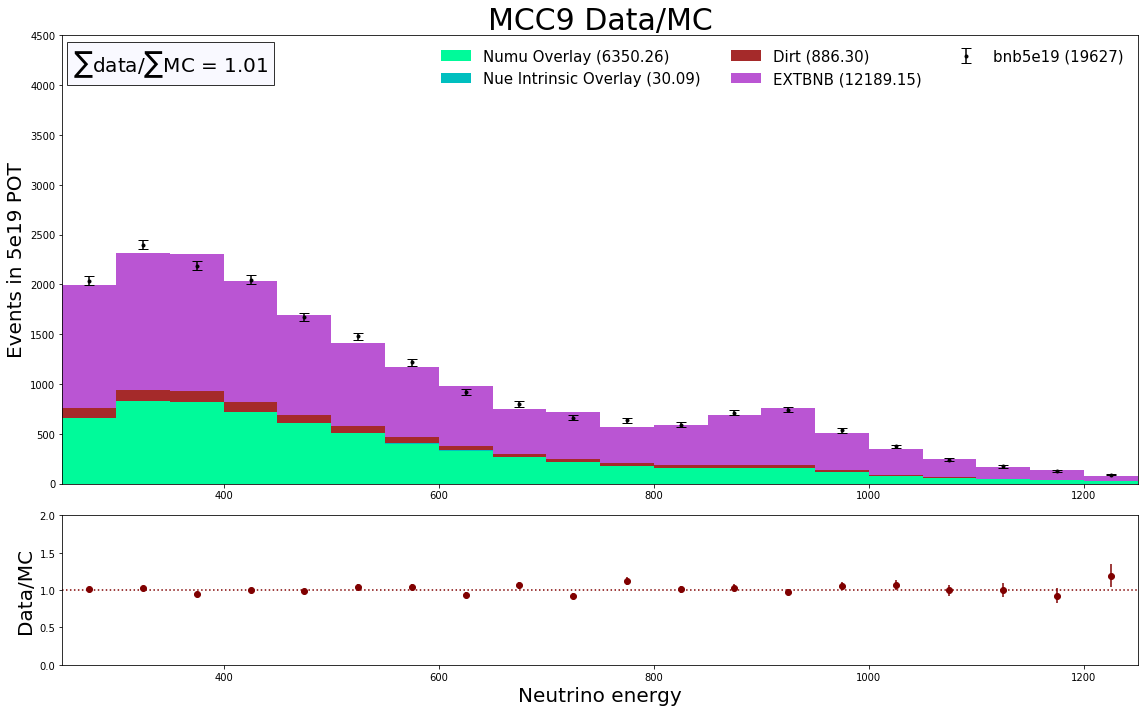

In [7]:
var_numu = df_numu_presel['Enu_1m1p'].values
var_nue = df_nue_presel['Enu_1m1p'].values
var_ext = df_ext_presel['Enu_1m1p'].values
var_data = df_data_presel['Enu_1m1p'].values
var_dirt = df_dirt_presel['Enu_1m1p'].values

fig,ax = plt.subplots(figsize=(16,10))
distplot_wratio(20,(250,1250),[var_numu,var_nue,var_dirt,var_ext],var_data,weights_data_presel,'Neutrino energy',4.5e3)
ax.annotate(r'Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.7,.7), xycoords='axes fraction',fontsize=15)
#ax.annotate('6808 Events in 5e19',xy=(.7,.6), xycoords='axes fraction',fontsize=20)

In [8]:
df_offvtx_numu_presel = df_numu_presel.query('scedir_corrected > 5')

df_CCQE_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType==1001')
df_MEC_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType==1000')

pizero = '(interactionType==1090 or interactionType==1086 or interactionType==1080 or interactionType==1015 or interactionType==1013 or interactionType==1011 or interactionType==1008 or interactionType==1006 or interactionType==1004)'
piplusminus= '(interactionType==1085 or interactionType==1079 or interactionType==1032 or interactionType==1017 or interactionType==1014 or interactionType==1007 or interactionType==1005 or interactionType==1003 or interactionType==1028 or interactionType==1021 or interactionType==1016 or interactionType==1012 or interactionType==1010 or interactionType==1009)'

df_pizero_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and '+pizero)
df_piplusminus_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and '+piplusminus)
df_other_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType!=1001 and interactionType!=1000 and not '+pizero+' and not '+piplusminus)

weights_offvtxnumu_presel = df_offvtx_numu_presel['geniereweight']*NUMU_SCALE
weights_CCQEnumu_presel = df_CCQE_numu_presel['geniereweight']*NUMU_SCALE
weights_MECnumu_presel = np.ones(len(df_MEC_numu_presel))*NUMU_SCALE
weights_PIZEROnumu_presel = np.ones(len(df_pizero_numu_presel))*NUMU_SCALE
weights_PIPLUSMINUSnumu_presel = np.ones(len(df_piplusminus_numu_presel))*NUMU_SCALE
weights_OTHERnumu_presel = np.ones(len(df_other_numu_presel))*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight']*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
weights_dirt_presel = np.ones(len(df_dirt_presel))*DIRT_SCALE


a_weights = [weights_CCQEnumu_presel,weights_MECnumu_presel,weights_PIZEROnumu_presel,weights_PIPLUSMINUSnumu_presel,weights_OTHERnumu_presel,weights_offvtxnumu_presel,weights_nue_presel,weights_dirt_presel,weights_ext_presel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]

a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','Dirt','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','peru','fuchsia']

Events: 19627.0
MC:  19455.792358874896


Text(0.75, 0.6, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

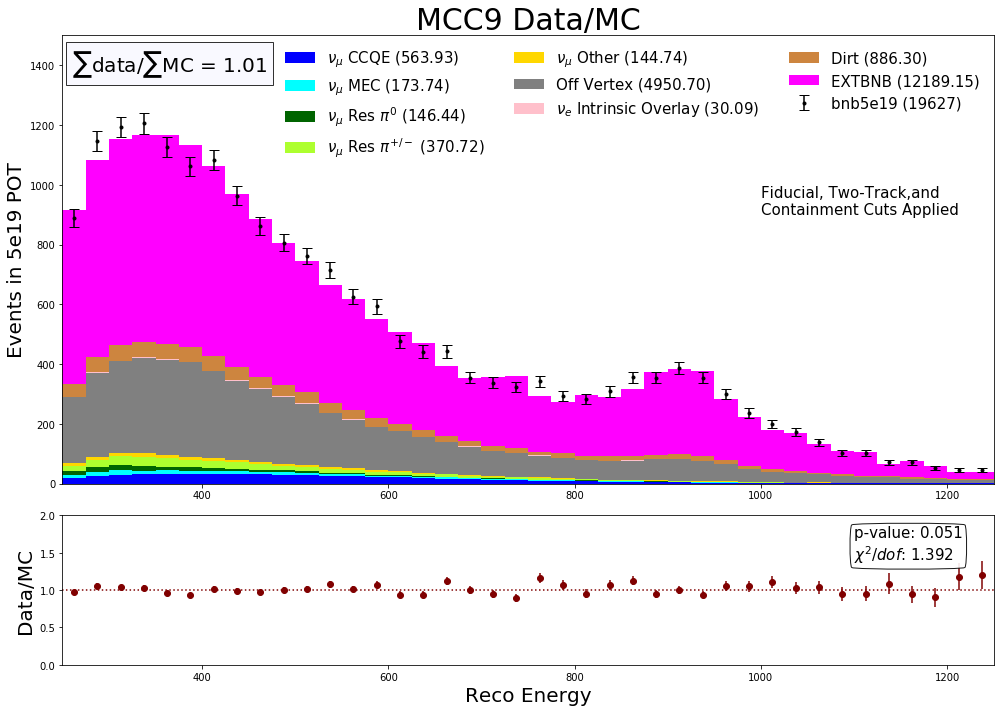

In [9]:
vartest = 'Enu_1m1p'
varname = 'Reco Energy'
myrange = (250,1250)
nbins = 40
yscale = 1.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Events: 20111.0
MC:  19897.61482888163


Text(0.75, 0.6, 'Fiducial, Two-Track,and \nContainment Cuts Applied')

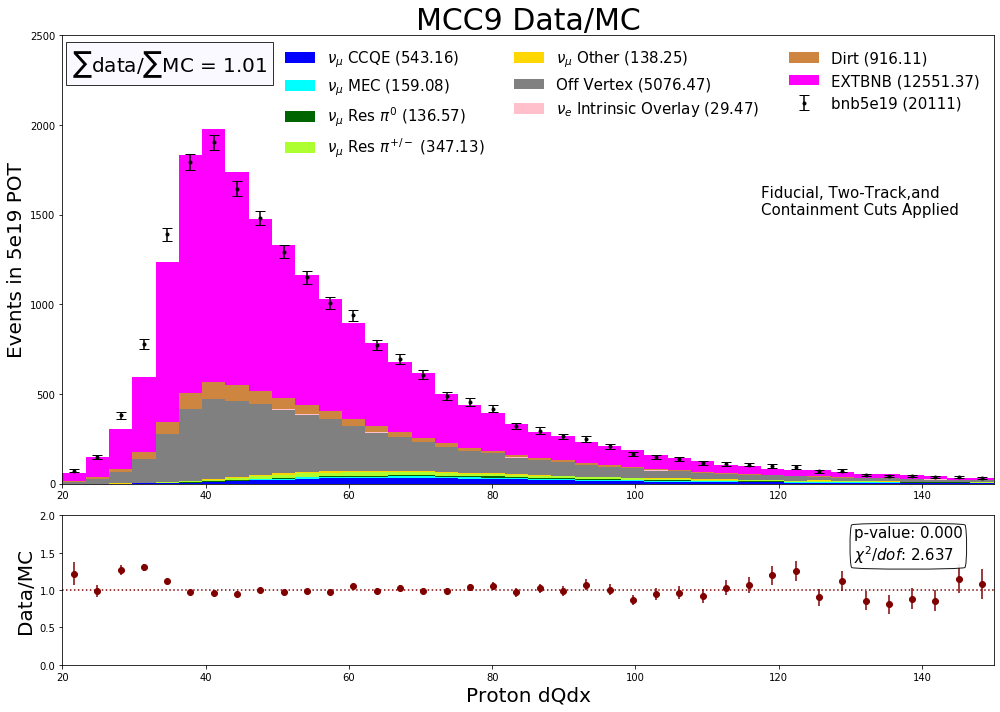

In [10]:
vartest = 'Proton_dQdx'
varname = 'Proton dQdx'
myrange = (20,150)
nbins = 40
yscale = 2.5e3

var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,varname,yscale,True)
ax0.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

# Apply Selection

In [11]:
# We're doing things different now! Load up the weights themselves.
with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_sparsenet_vd2.pickle','rb') as handle: [cosmicBDT,nubkgBDT] = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation

#jarretvars = ['SphB_1m1p','PzEnu_1m1p','BjXB_1m1p','BjYB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','OpenAngB_1m1p','PT_1m1p']
#jarretvars = ['BjXB_1m1p','BjYB_1m1p','PT_1m1p','SphB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','Q0_1m1p','Q3_1m1p','ChargeNearTrunk','Phis','ThetasB_1m1p','LongTrackLen','PTRat_1m1p','PzEnu_1m1p','Lepton_dQdx']
#jarretvars = ['BjXB_1m1p','BjYB_1m1p','PT_1m1p','SphB_1m1p','Proton_ThetaRecoB_1m1p','Muon_ThetaRecoB_1m1p','Eta','Q0_1m1p','Q3_1m1p','ChargeNearTrunk','Phis','LongTrackLen','PTRat_1m1p','PzEnu_1m1p']
jarretvars = ['Enu_1m1p','Eta','ChargeNearTrunk','OpenAngB_1m1p','PTB_1m1p','AlphaTB_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','PzEnu_1m1p','Q0_1m1p','Q3_1m1p','ThetasB_1m1p','PhisB_1m1p','PTRat_1m1p','LongTrackLen','Proton_PhiRecoB_1m1p','Proton_ThetaRecoB_1m1p']



In [12]:
df_offvtx_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_offvtx_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_CCQE_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_CCQE_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_MEC_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_MEC_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_pizero_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_pizero_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_piplusminus_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_piplusminus_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_other_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_other_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_ext_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_ext_presel[jarretvars].values.tolist(),output_margin=True))
df_data_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_data_presel[jarretvars].values.tolist(),output_margin=True))
df_nue_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_nue_presel[jarretvars].values.tolist(),output_margin=True))
df_numu_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_dirt_presel.insert(0,'CosBkgScore',cosmicBDT.predict(df_dirt_presel[jarretvars].values.tolist(),output_margin=True))

In [13]:
df_offvtx_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_offvtx_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_CCQE_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_CCQE_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_MEC_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_MEC_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_pizero_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_pizero_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_piplusminus_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_piplusminus_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_other_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_other_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_ext_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_ext_presel[jarretvars].values.tolist(),output_margin=True))
df_data_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_data_presel[jarretvars].values.tolist(),output_margin=True))
df_nue_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_nue_presel[jarretvars].values.tolist(),output_margin=True))
df_numu_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_numu_presel[jarretvars].values.tolist(),output_margin=True))
df_dirt_presel.insert(0,'NuBkgScore',nubkgBDT.predict(df_dirt_presel[jarretvars].values.tolist(),output_margin=True))

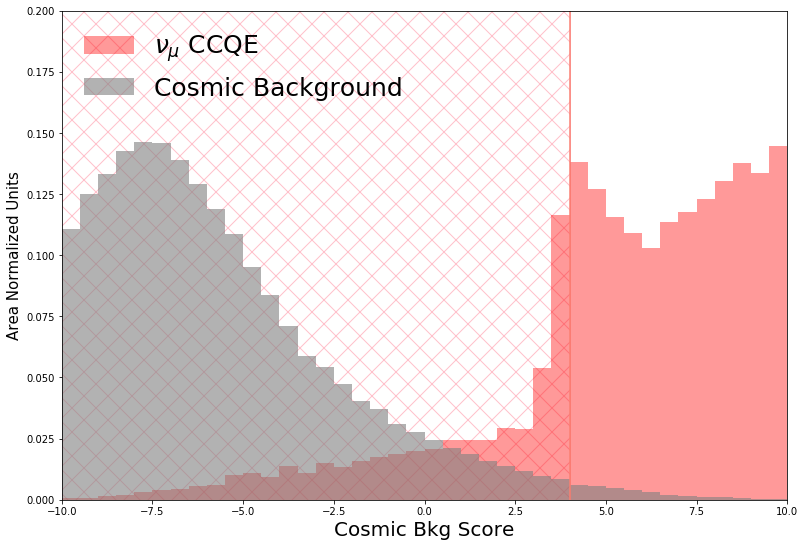

In [20]:
#Plot bdt variables

nuquery = 'NTracks ==2'

cosbkg_signal = df_CCQE_numu_presel.query(nuquery)['CosBkgScore'].values
cosbkg_bkg = df_ext_presel.query(nuquery)['CosBkgScore'].values.tolist() + df_offvtx_numu_presel.query(nuquery)['CosBkgScore'].values.tolist()

fig,ax = plt.subplots(figsize=(13,9))
fig.patch.set_alpha(1)
nbins = 40
myrange = (-10,10)

plt.hist(cosbkg_signal,nbins,range=myrange,color='red',alpha=.4,density=True,label=r'$\nu_\mu$ CCQE')
plt.hist(cosbkg_bkg,nbins,range=myrange,color='grey',alpha=.6,density=True,label='Cosmic Background')
ax.set_xlabel('Cosmic Bkg Score',fontsize=20)
ax.set_ylabel('Area Normalized Units',fontsize=15)

ax.axvline(4,c='salmon')
plt.fill_between((-14,4),(0,0),(10,10),hatch='X',facecolor='None',edgecolor='pink',alpha=1)
ax.set_ylim(0,.20)
ax.set_xlim(myrange)
#ax.annotate('Cut CosBkgScore < 0\nReject 98.9% Bkg\nRetain 80.10% Sig',xy=(.72,.65), xycoords='axes fraction',fontsize=18)


plt.legend(fontsize=25,frameon=False)

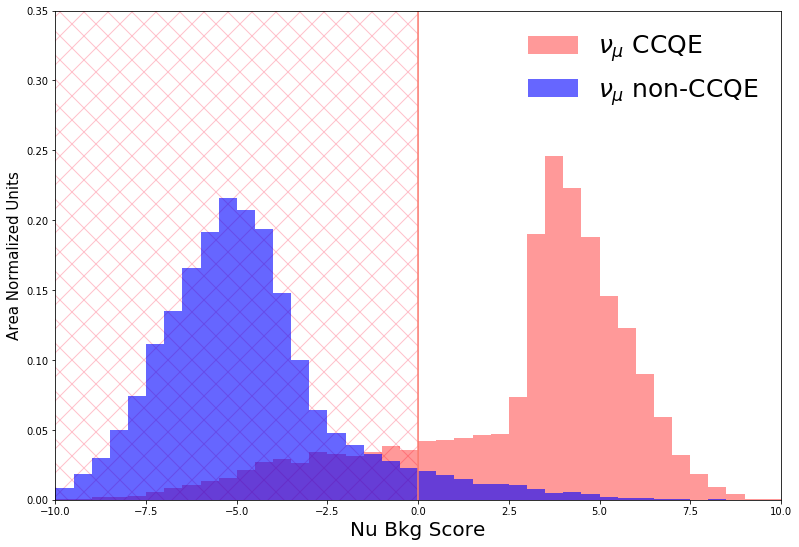

In [22]:
#Plot bdt variables

cosquery = 'NTracks == 2'


nubkg_signal = df_CCQE_numu_presel.query(cosquery)['NuBkgScore'].values
nubkg_bkg = df_MEC_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() + df_piplusminus_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() + df_pizero_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() +  df_other_numu_presel.query(cosquery)['NuBkgScore'].values.tolist()



fig,ax = plt.subplots(figsize=(13,9))
fig.patch.set_alpha(1)
nbins = 40
myrange = (-10,10)

plt.hist(nubkg_signal,nbins,range=myrange,color='red',alpha=.4,density=True,label=r'$\nu_\mu$ CCQE')
plt.hist(nubkg_bkg,nbins,range=myrange,color='blue',alpha=.6,density=True,label=r'$\nu_\mu$ non-CCQE')

ax.set_xlabel('Nu Bkg Score',fontsize=20)
ax.set_ylabel('Area Normalized Units',fontsize=15)

ax.axvline(0,c='salmon')
plt.fill_between((-14,0),(0,0),(10,10),hatch='X',facecolor='None',edgecolor='pink',alpha=1)
ax.set_ylim(0,.35)
ax.set_xlim(myrange)
#ax.annotate('Cut NuBkgScore < 0\nReject 93.47% Bkg\nRetain 78.74% Sig',xy=(.72,.65), xycoords='axes fraction',fontsize=18)


plt.legend(fontsize=25,frameon=False)

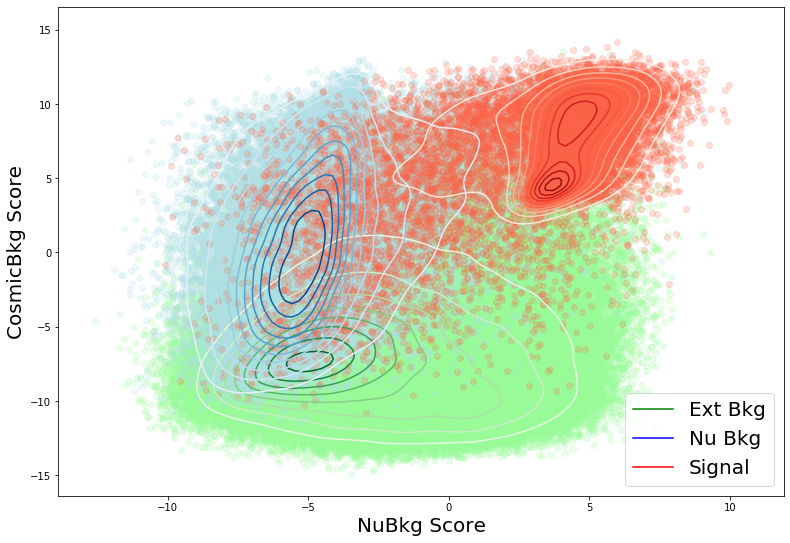

In [27]:
nubkg_signal = df_CCQE_numu_presel.query(cosquery)['NuBkgScore'].values
nubkg_nubkg = df_MEC_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() + df_piplusminus_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() + df_pizero_numu_presel.query(cosquery)['NuBkgScore'].values.tolist() +  df_other_numu_presel.query(cosquery)['NuBkgScore'].values.tolist()
nubkg_cosbkg = df_ext_presel.query(nuquery)['NuBkgScore'].values.tolist() + df_offvtx_numu_presel.query(nuquery)['NuBkgScore'].values.tolist()

cosbkg_signal = df_CCQE_numu_presel.query(cosquery)['CosBkgScore'].values
cosbkg_nubkg = df_MEC_numu_presel.query(cosquery)['CosBkgScore'].values.tolist() + df_piplusminus_numu_presel.query(cosquery)['CosBkgScore'].values.tolist() + df_pizero_numu_presel.query(cosquery)['CosBkgScore'].values.tolist() +  df_other_numu_presel.query(cosquery)['CosBkgScore'].values.tolist()
cosbkg_cosbkg = df_ext_presel.query(nuquery)['CosBkgScore'].values.tolist() + df_offvtx_numu_presel.query(nuquery)['CosBkgScore'].values.tolist()


fig,ax = plt.subplots(figsize=(13,9))
fig.patch.set_alpha(1)

ax.set_xlabel('NuBkg Score',fontsize=20)
ax.set_ylabel('CosmicBkg Score',fontsize=20)


plt.scatter(nubkg_cosbkg,cosbkg_cosbkg,color='palegreen',alpha=.2)
plt.scatter(nubkg_nubkg,cosbkg_nubkg,color='powderblue',alpha=.2)
plt.scatter(nubkg_signal,cosbkg_signal,color='tomato',alpha=.2)
sns.kdeplot(nubkg_cosbkg,cosbkg_cosbkg,label='Ext Bkg',color='green',cmap='Greens')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(nubkg_nubkg,cosbkg_nubkg,label='Nu Bkg',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(nubkg_signal,cosbkg_signal,color='red',cmap='Reds',label='Signal')#,cmap="Reds", shade=True, bw=.15)


plt.legend(fontsize=20,loc='lower right')


Events: 20601.0
MC:  20361.659195444456


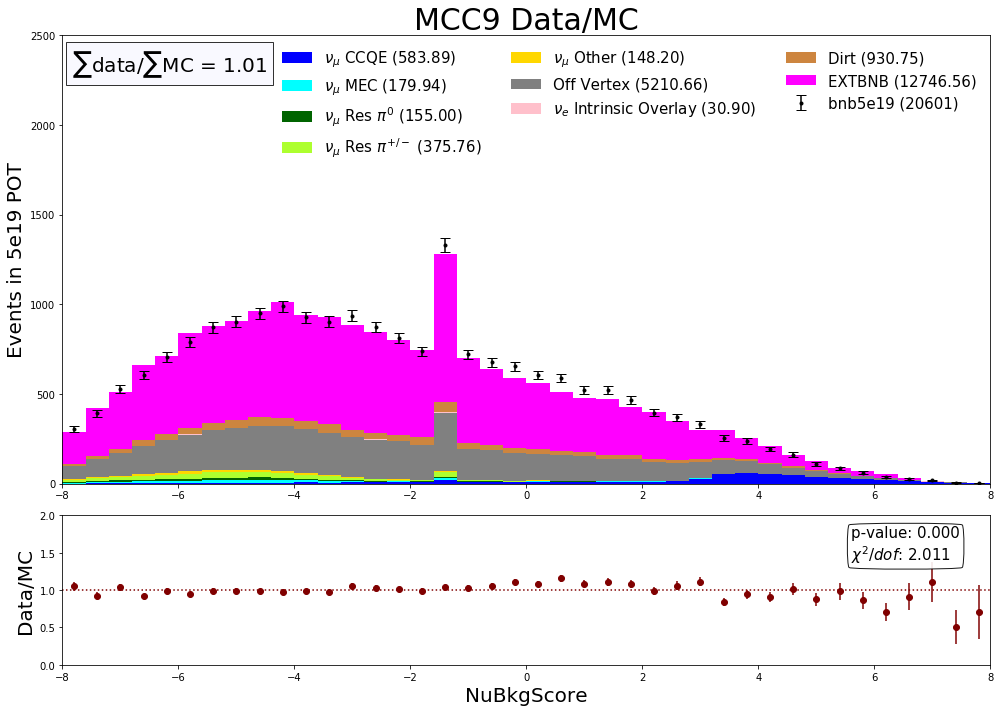

In [29]:
vartest = 'NuBkgScore'
var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(40,(-8,8),[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,vartest,2.5e3,True)
#ax0.annotate('Bump Cut',xy=(.72,.65), xycoords='axes fraction',fontsize=18)

Events: 12848.0
MC:  12537.452396565526


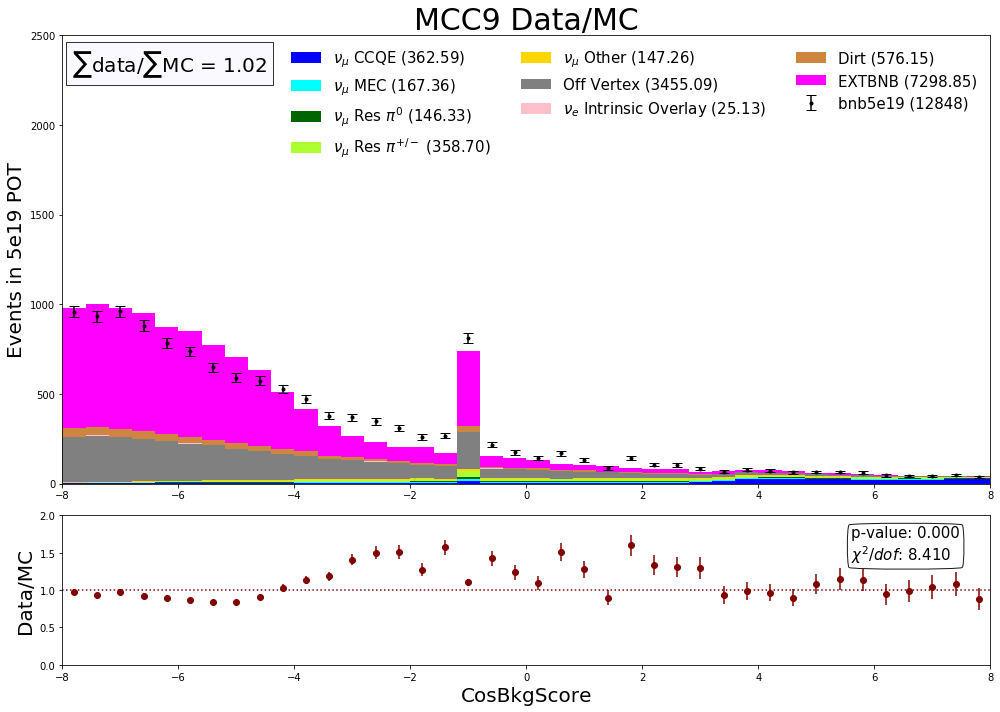

In [31]:
vartest = 'CosBkgScore'
var_offvtx = df_offvtx_numu_presel[vartest].values
var_ccqe = df_CCQE_numu_presel[vartest].values 
var_mec = df_MEC_numu_presel[vartest].values
var_pizero = df_pizero_numu_presel[vartest].values
var_piplusminus = df_piplusminus_numu_presel[vartest].values
var_other = df_other_numu_presel[vartest].values
var_nue = df_nue_presel[vartest].values
var_ext = df_ext_presel[vartest].values
var_data = df_data_presel[vartest].values
var_dirt = df_dirt_presel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(40,(-8,8),[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_presel,vartest,2.5e3,True)
#ax0.annotate('Bump Cut',xy=(.72,.65), xycoords='axes fraction',fontsize=18)

In [22]:
# Now, let's apply cuts.
augcuts = '(NuBkgScore > 2 and CosBkgScore > 0)'
loosecuts = '(NuBkgScore > 0 and CosBkgScore > 0)'
specialcuts = augcuts + ' and Zreco < 700 and Zreco > 500 and Proton_dQdx > 83'
phicuts = augcuts + ' and Proton_PhiReco  > -1 and eta < .5 and Proton_dQdx < 90'
bumpcuts = augcuts + ' and Proton_dQdx < 90'
isolatebump = augcuts + ' and Proton_dQdx > 90 and Proton_dQdx  < 110'
isolatebad = augcuts + ' and  Proton_dQdx > 60'
isolatenaughty = augcuts + ' and BDTprob == -1'
bestcut = 'NuBkgScore > 0 and CosBkgScore > 2 and BDTprob != -1'
nocuts = 'good==1'

s_cuts = 'CosBkgScore > 4 and NuBkgScore > 0'# and Proton_dQdx < 90'# and (Proton_dQdx < 90 or Proton_dQdx  > 110)'

s_anno = 'Fiducial, Two-Track,and \nContainment Precuts;\nCosBkgScore > 2\nNuBkgScore > 0'

s_ano_simple_w = wrap('Precuts and '+s_cuts,28)
s_ano_simple = '' 
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'

In [23]:
df_CCQE_numu_sel = df_CCQE_numu_presel.query(s_cuts)
df_MEC_numu_sel = df_MEC_numu_presel.query(s_cuts)
df_pizero_numu_sel = df_pizero_numu_presel.query(s_cuts)
df_piplusminus_numu_sel = df_piplusminus_numu_presel.query(s_cuts)
df_other_numu_sel = df_other_numu_presel.query(s_cuts)
df_offvtx_numu_sel = df_offvtx_numu_presel.query(s_cuts)
df_numu_sel = df_numu_presel.query(s_cuts)
df_nue_sel = df_nue_presel.query(s_cuts)
df_ext_sel = df_ext_presel.query(s_cuts)
df_data_sel = df_data_presel.query(s_cuts)
df_dirt_sel = df_dirt_presel.query(s_cuts)

weights_CCQE_numu_sel = df_CCQE_numu_sel['geniereweight']*NUMU_SCALE
weights_MEC_numu_sel = df_MEC_numu_sel['geniereweight']*NUMU_SCALE
weights_pizero_numu_sel = df_pizero_numu_sel['geniereweight']*NUMU_SCALE
weights_piplusminus_numu_sel = df_piplusminus_numu_sel['geniereweight']*NUMU_SCALE
weights_other_numu_sel = df_other_numu_sel['geniereweight']*NUMU_SCALE
weights_offvtx_numu_sel = df_offvtx_numu_sel['geniereweight']*NUMU_SCALE
weights_numu_sel = df_numu_sel['geniereweight']*NUMU_SCALE
weights_nue_sel = df_nue_sel['geniereweight']*NUE_SCALE
weights_ext_sel = np.ones(len(df_ext_sel))*EXT_SCALE
weights_data_sel = np.ones(len(df_data_sel))
weights_dirt_sel = np.ones(len(df_dirt_sel))*DIRT_SCALE

a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_dirt_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,DIRT_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','Dirt','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','brown','fuchsia']

Events: 483.0
MC:  505.54092121800136


Text(0.7, 0.55, 'Precuts and CosBkgScore > 4\nand NuBkgScore > 0\n')

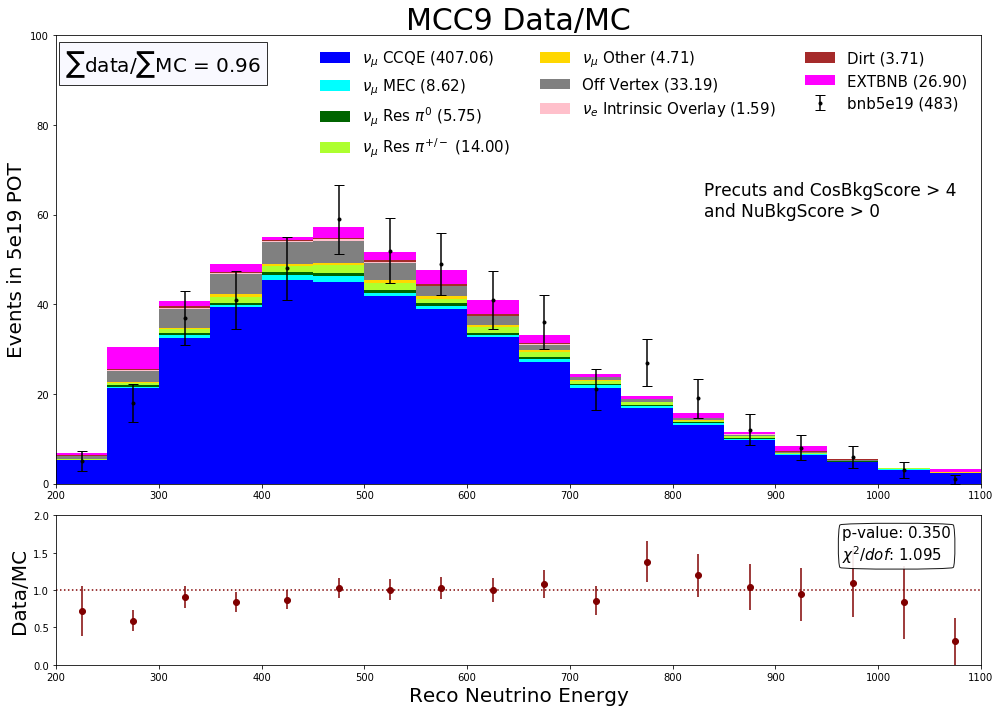

In [26]:
vartest = 'Enu_1m1p'
myrange = (200,1100)
nbins = 18
axtitle = 'Reco Neutrino Energy'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,axtitle,1E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

In [29]:
#df_nue_presel[['run','subrun','event','Enu_1m1p','geniereweight']].to_csv('nue_preselection-withrw.txt',index=False)
df_data_sel[['run','subrun','event']].to_csv('bnb5e19_1m1pselection-jan21-RSE.txt',index=False)

In [ ]:
df_numu_sel.to_pickle('bnb_overlay_1m1p.pkl',protocol=2)

Events: 453.0
MC:  473.89828308889247


Text(0.7, 0.55, 'Precuts and CosBkgScore > 4\nand NuBkgScore > 0\n')

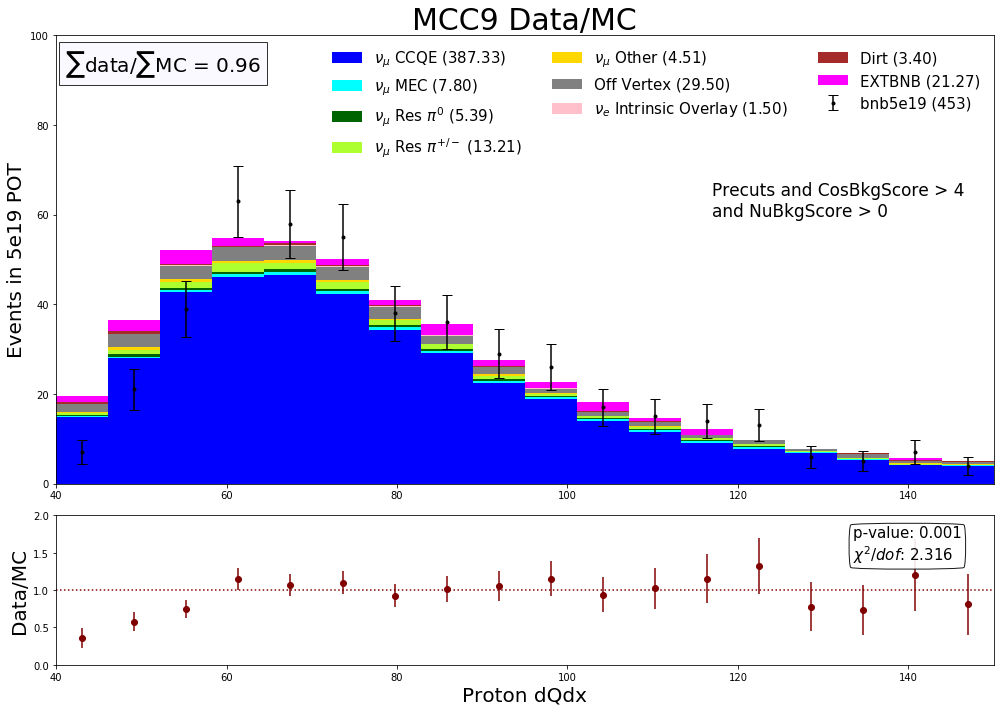

In [28]:
vartest = 'Proton_dQdx'
myrange = (40,150)
nbins = 18
axtitle = 'Proton dQdx'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values
var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values
var_dirt = df_dirt_sel[vartest].values

fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_dirt,var_ext],var_data,weights_data_sel,axtitle,1E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

Events: 335.0
MC:  354.3891551446084


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


Text(0.7, 0.55, 'Precuts and CosBkgScore > 4\nand NuBkgScore > 0\n')

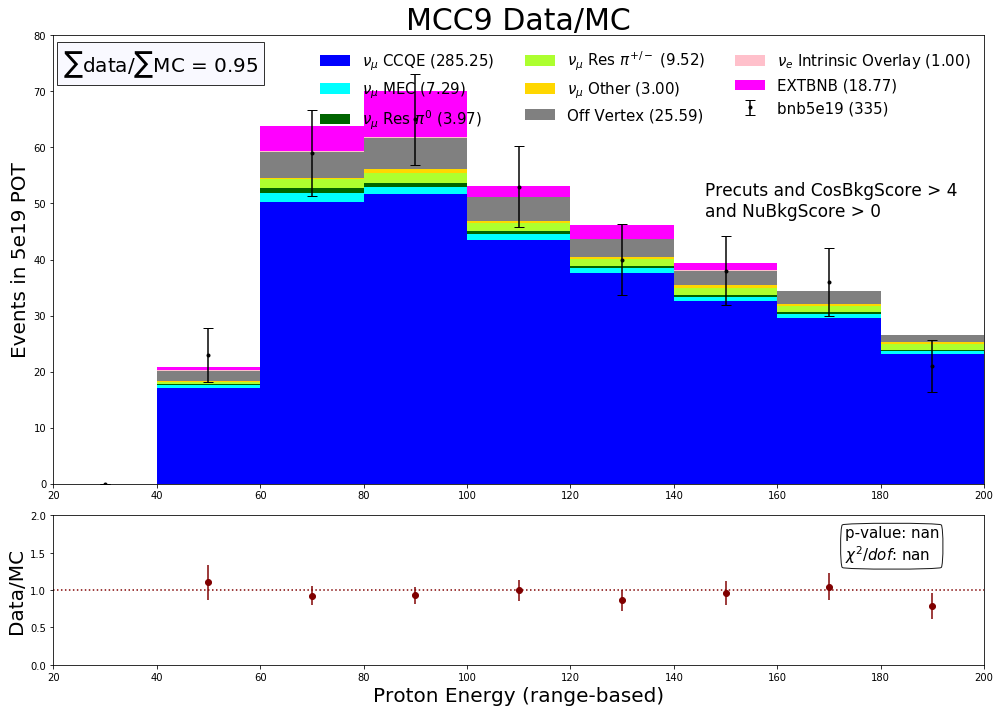

In [41]:
vartest = 'Proton_Edep'
myrange = (20,200)
nbins = 9
axtitle = 'Proton Energy (range-based)'

var_offvtx = df_offvtx_numu_sel[vartest].values
var_ccqe = df_CCQE_numu_sel[vartest].values 
var_mec = df_MEC_numu_sel[vartest].values
var_pizero = df_pizero_numu_sel[vartest].values
var_piplusminus = df_piplusminus_numu_sel[vartest].values
var_other = df_other_numu_sel[vartest].values

var_nue = df_nue_sel[vartest].values
var_ext = df_ext_sel[vartest].values
var_data = df_data_sel[vartest].values


a_weights = [weights_CCQE_numu_sel,weights_MEC_numu_sel,weights_pizero_numu_sel,weights_piplusminus_numu_sel,weights_other_numu_sel,weights_offvtx_numu_sel,weights_nue_sel,weights_ext_sel]
a_scale = [NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUMU_SCALE,NUE_SCALE,EXT_SCALE]
a_labels = [r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other','Off Vertex',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['blue','cyan','darkgreen','greenyellow','gold','grey','pink','fuchsia']
fig,ax = plt.subplots(figsize=(14,10))
ax0 = distplot_wratio(nbins,myrange,[var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_offvtx,var_nue,var_ext],var_data,weights_data_sel,axtitle,.8E2,True)
ax0.annotate(s_ano_simple,xy=(.7,.55), xycoords='axes fraction',fontsize=17)

(0, 1000)

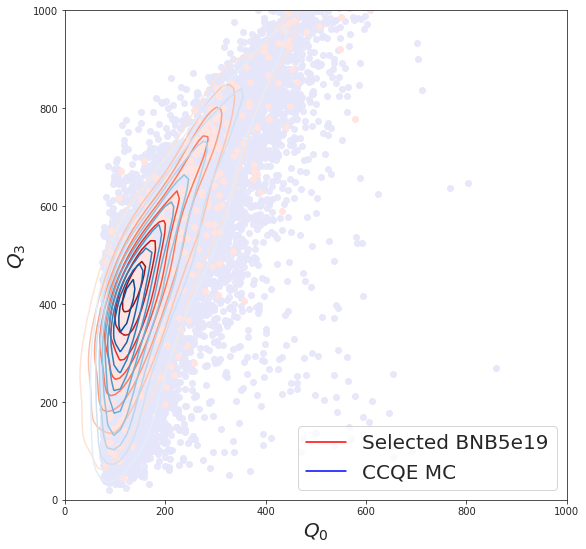

In [45]:
data_q0 = df_data_sel['Q0_1m1p'].values
data_q3 = df_data_sel['Q3_1m1p'].values

data_q0 = data_q0[data_q0>=0]
data_q3 = data_q3[data_q3>=0]

ccqe_q0 = df_CCQE_numu_presel['Q0_1m1p'].values
ccqe_q3 = df_CCQE_numu_presel['Q3_1m1p'].values

ccqe_q0 = ccqe_q0[ccqe_q0>=0]
ccqe_q3 = ccqe_q3[ccqe_q3>=0]

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(ccqe_q0,ccqe_q3,color='lavender',alpha=.9)
plt.scatter(data_q0,data_q3,color='mistyrose',alpha=1)
sns.kdeplot(data_q0,data_q3,label='Selected BNB5e19',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)
sns.kdeplot(ccqe_q0,ccqe_q3,label='CCQE MC',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)

ax.set_xlabel(r'$Q_0$',fontsize=20)
ax.set_ylabel(r'$Q_3$',fontsize=20)
plt.legend(fontsize=20,loc='lower right')
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(0,1000)
plt.ylim(0,1000)

(60, 1000)

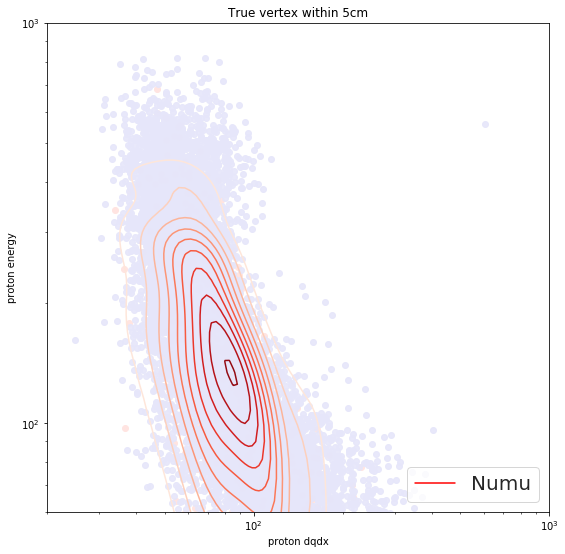

In [30]:
dataprotonE = df_data_sel['Proton_Edep'].values
datadqdx = df_data_sel['Proton_dQdx'].values

#mcprotone = df_nue_sel.query('scedir_corrected < 5')['Proton_Edep'].values.tolist() + df_numu_sel.query('scedir_corrected < 5')['Proton_Edep'].values.tolist()
#mcdqdx = df_nue_sel.query('scedir_corrected < 5')['Proton_dQdx'].values.tolist() + df_numu_sel.query('scedir_corrected < 5')['Proton_dQdx'].values.tolist()

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(datadqdx,dataprotonE,color='mistyrose',alpha=1)
plt.scatter(mcdqdx,mcprotone,color='lavender',alpha=.9)
sns.kdeplot(datadqdx,dataprotonE,label='Numu',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)
#sns.kdeplot(mcdqdx,mcprotone,label='Nue',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)

ax.set_xlabel('proton dqdx')
ax.set_ylabel('proton energy')
plt.legend(fontsize=20,loc='lower right')
plt.title('True vertex within 5cm')
plt.yscale('log')
plt.xscale('log')
plt.xlim(20,1000)
plt.ylim(60,1000)

In [ ]:
print(mcdqdx)

In [ ]:
vary = df_data_sel['Xreco'].values
varz = df_data_sel['Zreco'].values

fig,ax = plt.subplots(figsize=(12,4))
datahist = plt.hist2d(varz,vary,(20,9),((0,1036),(0,232)),vmax=3)

#plt.hist2d(x, y, bins=40, norm=LogNorm())
plt.colorbar()
plt.title('bnb5e19 Data')
ax.set_ylabel('X Reco',fontsize=20)
ax.set_xlabel('Z Reco',fontsize=20)

vary = df_nue_sel['Xreco'].values.tolist() + df_numu_sel['Xreco'].values.tolist() + df_ext_sel['Xreco'].values.tolist()
varz = df_nue_sel['Zreco'].values.tolist() + df_numu_sel['Zreco'].values.tolist() + df_ext_sel['Zreco'].values.tolist()

fig,ax = plt.subplots(figsize=(12,4))
mchist = plt.hist2d(varz,vary,(20,9),((0,1036),(0,232)),weights =weights_nue_sel.tolist()+weights_numu_sel.tolist()+weights_ext_sel.tolist(),vmax=3)

#plt.hist2d(x, y, bins=40, norm=LogNorm())
plt.colorbar()
plt.title('MC+ExtBNB')
ax.set_ylabel('X Reco',fontsize=20)
ax.set_xlabel('Z Reco',fontsize=20)


fig,ax = plt.subplots(figsize=(12,4))
plt.imshow(np.transpose(np.flip(datahist[0]-mchist[0],1)),aspect='auto',extent=(0,1036,0,232))
#plt.imshow(np.transpose(datahist[0])-np.transpose(mchist[0]),

plt.colorbar()
plt.title('Data - (MC+ExtBNB)')
ax.set_ylabel('X Reco',fontsize=20)
ax.set_xlabel('Z Reco',fontsize=20)